# This is a copy of Jonathan's IA modelling notebook

Notebook by: Jonathan Blazek (blazek@berkeley.edu)  
FAST-PT on github: https://github.com/JoeMcEwen/FAST-PT  
Easy ccl installation in a conda environment: `conda install -c conda-forge pyccl`  
Easy fast-pt installation: `pip install fast-pt`  
(Note, use `--no-deps` if you use `conda` for most python packages)

In [1]:
# import standard packages
import numpy as np
import pylab as plt
%matplotlib inline
from scipy.interpolate import interp1d

# import fastpt
import fastpt as fpt
import fastpt.HT as HT

# import the Core Cosmology Library (CCL) if you have it
try:
    import pyccl as ccl
    import pyccl.ccllib as lib
    import pyccl.nl_pt as pt
    have_ccl = True
except:
    have_ccl = False
    print('CCL not found. Steps with CCL will be skipped.')

# If you want to test HT against external Bessel transform code, e.g. mcfit
try:
    from mcfit import P2xi
    have_mcfit = True
except:
    have_mcfit = False
    print('mcfit not found. Steps with mcfit will be skipped.')
    
import params_DESY1_testpz as pa

mcfit not found. Steps with mcfit will be skipped.


<h3> FAST-PT includes an implementation of FFTLog for Bessel transforms. </h3>

<h3> $w_{g+}$ is a $J_2$ transform</h3>

In [2]:
# We want to load the 3D power spectrum we are using to get Delta Sigma - this is the galaxy-matter power spectrum
# Let's just do this at a single value of redshift for now (the lowest z). We add the 1halo and 2halo together.

k_2h, Pk_2h = np.loadtxt('./txtfiles/halofit_Pk/Pk_nonlin_z=0.300150963095_DESHoD.txt', unpack=True)
k_1h, Pk_1h = np.loadtxt('./txtfiles/1halo_terms/Pk1h_ldm_z=0.300150963095_DESHoD.txt', unpack=True)

In [3]:
Pk_1h2h = Pk_1h+pa.bd*Pk_2h # bd is the bias of the lens again

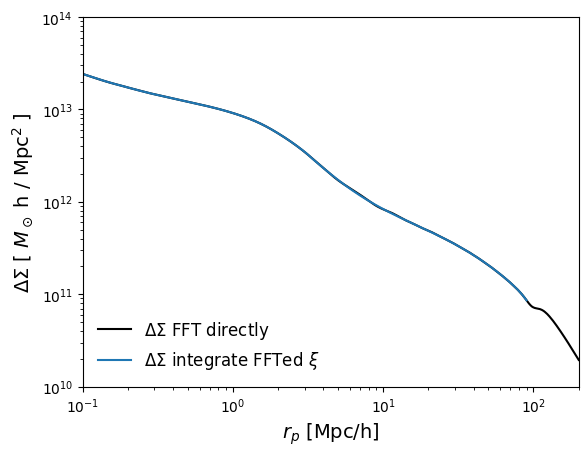

In [4]:
# In the Limber approximation, w_g+ is a simple calculation:

# Load the case from Danielle's code which uses xi_gm as calculated via FFT from P(k):
rp_DL, DelSig_DL = np.loadtxt('./txtfiles/DeltaSigma_1h2h_z[0]_fix1halo_fastPTxi.txt', unpack=True)

rp_DL[0] = 0.0001

# For the J2 transform (e.g. DeltaSigma or w_g+)
# This is very much not normalised properly. I have checked that k_1h and k_2h are the same.
# Here we directly FFT from P(k) from Danielle's code to get Delta Sigma vias the J2 transform.
r, DelSig_unnorm =HT.k_to_r(k_1h,Pk_1h2h,1.,-1.,2., 1./(2*np.pi))

r[0]=0.0001

# Get rho_m in comoving coordinates (independent of redshift)
rho_crit = 3. * 10**10 * pa.mperMpc / (8. * np.pi * pa.Gnewt * pa.Msun)  # Msol h^2 / Mpc^3, for use with M in Msol / h (comoving distances)
rho_m = (pa.OmC_t + pa.OmB) * rho_crit # units of Msol h^2 / Mpc^3 (comoving distances)

DelSig = DelSig_unnorm * rho_m

# Make a plot
plt.plot(r,DelSig, 'k', label=r'$\Delta \Sigma$ FFT directly')
plt.plot(rp_DL, DelSig_DL, label='$\Delta \Sigma$ integrate FFTed $\\xi$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r_p$ [Mpc/h]', fontsize=14)
plt.ylabel(r'$\Delta \Sigma$ [ $M_\odot$ h / Mpc$^2$ ]', fontsize=14)
plt.xlim(0.1,2e2)
plt.ylim(1e10,1e14)
plt.legend(loc='lower left', fontsize=12, frameon=False)

In [5]:
#Interpolate the version that is directly FFT'ed in this notebook for comparison
interp_DS = interp1d(r, DelSig)
# Get the version where xi is FFT'ed elsewhere then integrated at the same rp values
DS_interp = interp_DS(rp_DL[1:])

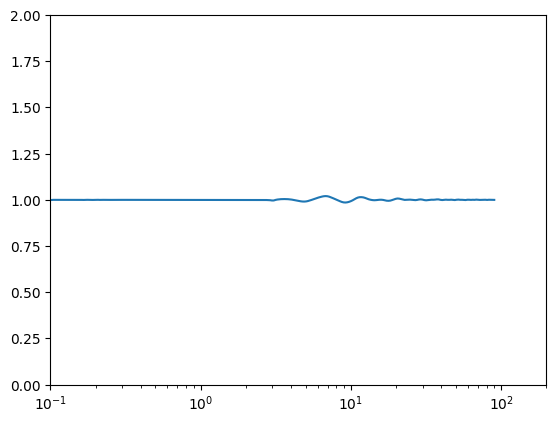

In [6]:
# Plot the ratio
plt.figure()
plt.semilogx(rp_DL[1:], DS_interp / DelSig_DL[1:])
plt.xlim(0.1,2e2)
plt.ylim(0,2)
plt.show()

Okay, so when I use my P(k) and FFT this to xi using the FFT functionality of Fast-PT then integrate to get Delta Sigma, this matches the case of where I use my P(k) and directly use the Fast-PT functionality to get Delta Sigma via FFT with J_2. 

This suggests that the issue was with the FFTlog implementation I was using.

Test xi as FFT'ed using Fast-PT vs xi as FFT'ed using CCL, both from my input P(k), just to be sure.

In [7]:
# Load xi_1h and xi_2h and combined (FFT'ed using Fast-PT) at a given redshift:

r_1h, xi_1h = np.loadtxt('./txtfiles/xi_1h_terms/xi1h_ldm_z=0.300150963095_DESHoD.txt', unpack=True)
r_2h, xi_2h = np.loadtxt('./txtfiles/halofit_xi/xi2h_z=0.300150963095_DESHoD.txt', unpack=True)

# I have verified that r_1h and r_2h are thes ame
# Replicate the truncation of the 1h term we do in the Delta Sigma calculation
for ri in range(0,len(r_1h)):
    if r_1h[ri]>3:
        xi_1h[ri] = 0.

# This is the version FFT'ed using FAST-pt
xi_1h2h = pa.bd*xi_2h + xi_1h # Multiply 2 halo term by the linear bias

In [8]:
# Okay, it turns out to compare with CCL, we seem to need load all the P(k) at all the z value
# Because correlation_3d wants a Pk2D object which is well-sampled in a and k.

zvec, dndzl_raw = np.loadtxt('./txtfiles/'+pa.dNdzL_file, unpack=True)

zsave = [0]*len(zvec)
for i in range(0,len(zvec)):
    zsave[i]=str('{:1.12f}'.format(zvec[i]))

In [9]:
zsave.reverse()

In [10]:
Pk1h_arr = np.zeros((len(zvec),len(k_1h)))
Pk2h_arr = np.zeros((len(zvec), len(k_1h)))
for zi in range(0,len(zvec)):
    k_temp, Pk2h_arr[zi,:] = np.loadtxt('./txtfiles/halofit_Pk/Pk_nonlin_z='+zsave[zi]+'_DESHoD.txt', unpack=True)
    k_temp, Pk1h_arr[zi,:] = np.loadtxt('./txtfiles/1halo_terms/Pk1h_ldm_z='+zsave[zi]+'_DESHoD.txt', unpack=True)
    
Pk1h2h_arr = Pk1h_arr + pa.bd*Pk2h_arr

In [11]:
# Now, use the CCL functionality to get xi from imported Pk_1h and Pk_2h:

cosmo = ccl.CosmologyVanillaLCDM() # This shouldn't matter because we pass in the P(k) but need to pass it.

In [12]:
pk2dobj = ccl.Pk2D(a_arr = 1./(1+zvec[::-1]), lk_arr = np.log(k_1h), pk_arr=np.log(Pk1h2h_arr), is_logp=True)

In [16]:
xi_1h2h_CCL = ccl.correlation_3d(cosmo, a=1./(1+0.3), r=r, p_of_k_a = pk2dobj)

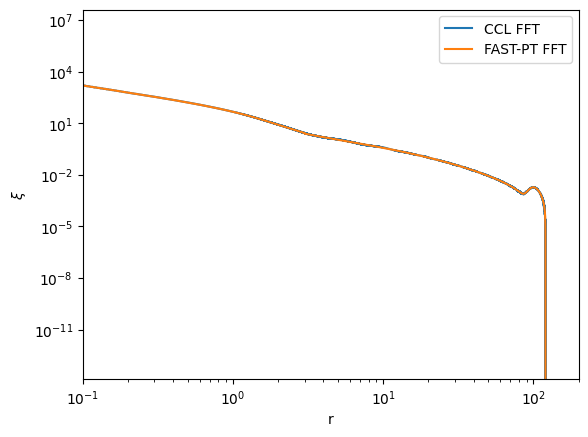

In [17]:
plt.figure()
plt.loglog(r, xi_1h2h_CCL, label='CCL FFT')
plt.loglog(r, xi_1h2h, label='FAST-PT FFT')
plt.legend()
plt.xlim(0.1,200)
plt.xlabel('r')
plt.ylabel('$\\xi$')
plt.show()

In [ ]:
# In the Limber approximation, w_g+ is a simple calculation:

# For the J2 transform (e.g. DeltaSigma or w_g+)
r,xi_2=HT.k_to_r(k,pk_nl0,1.,-1.,2., 4.*np.pi*np.sqrt(np.pi/2.))

# Make a plot
plt.plot(r,xi_2, 'k', label=r'$\xi_{lin}(k)$ cosmo 1')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$ [Mpc/h]', fontsize=14)
plt.ylabel(r'$w_{g+}$ [Mpc/h]', fontsize=14)
plt.xlim(1e0,2e2)
plt.ylim(1e1,1e4)
plt.legend(loc='lower left', fontsize=12, frameon=False)

In [ ]:
help(HT.k_to_r)

# Now we calculate the properly normalized version

In [ ]:
# note the correct pre-factor for w_g+ (see e.g. Blazek2015)
r,wgplus_tatt=HT.k_to_r(k,p_gI_tatt,1.,-1.,2., -1./(2*np.pi))
r,wgplus_nla=HT.k_to_r(k,p_gI_zz,1.,-1.,2., -1./(2*np.pi))
#r,wgplus_nla=HT.k_to_r(k,p_gI_zz,1.,-1.,2., 4.*np.pi*np.sqrt(np.pi/2.))
r,wgplus_nla_ccl=HT.k_to_r(k,p_gI_ccl,1.,-1.,2., -1./(2*np.pi))
r,wgplus_lin=HT.k_to_r(k,p_gI_zz_lin,1.,-1.,2., -1./(2*np.pi))

In [ ]:
#
out=np.ones((len(r),2))
out[:,0]=r
out[:,1]=wgplus_nla/b_1
np.savetxt('test05',out)

In [ ]:
# Make a plot
plt.plot(r,abs(wgplus_tatt), 'k', label=r'tatt')
plt.plot(r,abs(wgplus_nla), 'b', label=r'nla')
plt.plot(r,abs(wgplus_lin), 'g--', label=r'lin')
plt.plot(r,abs(wgplus_nla_ccl), 'r--', label=r'nla (CCL)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$', fontsize=14)
plt.ylabel(r'$w_{g+}$', fontsize=14)
plt.xlim(1e0,2e2)
plt.ylim(1e-3,1e0)
plt.legend(loc='upper right', fontsize=12, frameon=False)

Now we include the NFW profile modeling. We take the density profile, do a j0 transform to get the power spectrum, and then use the standard J2 transform to get the IA signal. This is adapted from old code and will be refactored when possible.

In [ ]:
#define some functions which will be needed. These will be moved out of the notebook.

def nfw_r(r,rho_s=1.,r_s=1.):
	"returns the halo density profile in 3d"
	a=r/r_s
	return rho_s/(a*(1.+a)**2)

def rho_bar0(Om_m0=Omega_m_0):
	h = 10**7/(3.086*10**24.)
	G = 6.67*10**-8.
	p = 3.*h*h/(8.*np.pi*G)/(1.99*10**33)*(3.086*10**24.)**3.
	return p*Om_m0
	
def rho_bar0_jab(Om_m0=Omega_m_0):
	h = 1.e5/(3.086e22)
	G = 6.674e-11
	p = 3.*h*h/(8.*np.pi*G)/(1.989e30)*(3.086e22)**3.
	return p*Om_m0

def Rvir(m,delta_vir=337.):
	mev = 10.**m
	return (3.*mev/(4.*delta_vir*np.pi*rho_bar0(Omega_m_0)))**(1./3.)

def A_c(c):
	return np.log(1.+c)-c/(1+c)

def rho_scale(c,z=0.,Om_m0=Omega_m_0,delta_vir=337):
	return rho_bar0(Omega_m_0)*c**3/A_c(c)*delta_vir/3
	#calculated in terms of comoving density, not physical density

def r_scale(M_vir,c,z=0.,Om_m0=Omega_m_0,delta_vir=337):
	return c**(-1)*((3.*M_vir)/(4.*np.pi*delta_vir*rho_bar0(Omega_m_0)))**(1./3)
	#calculated in terms of comoving density, not physical density

r_arr_nfw=np.logspace(-6,5,1000)
#r_arr_nfw = r

In [ ]:
print(Rvir(13,delta_vir=200))
print(rho_scale(6.295,z=0.,delta_vir=200))
print(rho_bar0()/Omega_m_0)
print(rho_bar0_jab())
print(Omega_m_0)

In [ ]:
def cvir_ldm(M_insol):
	""" Returns the concentration parameter of the NFW profile, c_{vir}. From Danielle Leonard. """

	cvi = 5. * (M_insol / 10**14)**(-0.1)
	
	return cvi

In [ ]:
# Set some halo parameters
#M_halo=9*10.**12 #original
#M_halo=10.**14. #testing for redmapper
#c_halo=5.*(M_halo/1.e14)**(-0.1) #original
#M_halo=10.**14.1 #redmapper

##
#M_halo=10.**13.7 #redmagic
#c_halo=5.*(M_halo/1.e14)**(-0.1) #original
# what about satellite fraction


#c_halo=5.#redmapper
#c_halo=50.*(M_halo/1.e14)**(-0.1) #extreme value
#delta_vir=180 # original

#M_halo=9.236709*10.**13 #comparison with Danielle Leonard
#c_halo= 5.039857767901646 #comparison with Danielle Leonard
#delta_vir=200 #comparison with danielle leonard

M_halo_noh=10.**13.6 #redmagic (not h units)
M_halo= h*M_halo_noh
c_halo=cvir_ldm(M_halo)
delta_vir=200

z_obs = zz #this is defined above. Should better connect the z values.
# Check the halo mass
# Check the approximations being made here.
# Update the redshift for the power spectra

In [ ]:
# Do calculations of halo profile
rho_s=rho_scale(c_halo,z=z_obs,delta_vir=delta_vir)
r_s=r_scale(M_halo,c_halo,z=z_obs,delta_vir=delta_vir)
R_vir=Rvir(np.log10(M_halo),delta_vir=delta_vir)
nfw_arr=nfw_r(r_arr_nfw,rho_s=rho_s,r_s=r_s)/(rho_bar0())

# Filtered version
#sm_scale = 2.0*R_vir
#nfw_arr_filt=nfw_arr*np.exp(-1.*(r_arr_nfw/sm_scale)**2)
sm_scale = 1.5*R_vir
nfw_arr_filt=nfw_arr*np.exp(-1.*(r_arr_nfw/sm_scale)**4)

In [ ]:
# Make a plot
plt.plot(r_arr_nfw,nfw_arr, 'k', label=r'NFW')
plt.plot(r_arr_nfw,nfw_arr_filt, 'r', label=r'NFW filt')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$ [Mpc]', fontsize=14)
plt.ylabel(r'$\rho(r)$', fontsize=14)
plt.xlim(2e-2,3e0)
plt.ylim(1e1,1e5)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [ ]:
# get the power spectrum
#r,xi = HT.k_to_r(k,pk_nl0,1.5,-1.5,.5, (2.*np.pi)**(-1.5))
k_nfw,P_nfw = HT.r_to_k(r_arr_nfw,nfw_arr,-1.5,1.5,.5, (2.*np.pi)**(1.5))
r_check,xi_check = HT.k_to_r(k_nfw,P_nfw,1.5,-1.5,.5, (2.*np.pi)**(-1.5))

# Make a plot
plt.plot(r_arr_nfw,nfw_arr, 'k', label=r'NFW')
plt.plot(r_check,xi_check, 'r', label=r'NFW round trip')
plt.plot(r_check,nfw_arr/xi_check, 'b', label=r'ratio')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$ [Mpc]', fontsize=14)
plt.ylabel(r'$\rho(r)$', fontsize=14)
plt.xlim(1e-3,3e0)
plt.ylim(0.9e0,1e7)
plt.legend(loc='upper right', fontsize=12, frameon=False)

print(min(k_nfw),max(k_nfw))
np.savetxt('k_nfw',k_nfw)
np.savetxt('P_nfw',P_nfw)

In [ ]:
#Compare with Danielle's NFW
nfw_danielle = np.loadtxt('danielle_nfw/Pkgm_1h_debug_Jonathan.txt')
k_dan=nfw_danielle[:,0]
P_dan=nfw_danielle[:,1]
r_dan,xi_dan=HT.k_to_r(k_dan,P_dan,1.5,-1.5,.5, (2.*np.pi)**(-1.5))

In [ ]:
p_jab_interp=interp1d(k_nfw,P_nfw,fill_value='extrapolate')
xi_jab_interp=interp1d(r_arr_nfw,nfw_arr,fill_value='extrapolate')
plt.plot(k_nfw,P_nfw, label=r'JAB')
plt.plot(nfw_danielle[:,0],nfw_danielle[:,1], label=r'DL')
plt.plot(nfw_danielle[:,0],nfw_danielle[:,1]/p_jab_interp(nfw_danielle[:,0]),label=r'ratio')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-3,1e3)
plt.ylim(1e-1,1e5)
plt.xlabel('$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$', fontsize=14)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [ ]:
plt.plot(nfw_danielle[:,0],nfw_danielle[:,1]/p_jab_interp(nfw_danielle[:,0]),label=r'ratio')
plt.xscale('log')
plt.xlim(1e-3,1e3)
plt.ylim(0,1.5)

In [ ]:
plt.plot(r_arr_nfw,nfw_arr, 'k', label=r'JAB')
plt.plot(r_dan,xi_dan, 'b', label=r'DL')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$ [Mpc]', fontsize=14)
plt.ylabel(r'$\rho(r)$', fontsize=14)
plt.xlim(1e-3,3e0)
plt.ylim(0.9e0,1e7)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [ ]:
plt.plot(r_dan,xi_dan/xi_jab_interp(r_dan), 'b', label=r'ratio')
plt.xscale('log')
plt.xlim(1e-3,3e0)
plt.ylim(0,1.5)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [ ]:
#1 halo contribution:
k_sm=10000.
P_IA_nfw = c_1_zz*P_nfw*np.exp(-1.*(k_nfw/k_sm)**2)
r_arr_nfw,wgplus_nfw_arr=HT.k_to_r(k_nfw,P_IA_nfw,1.,-1.,2., -1./(2*np.pi))

In [ ]:
# Make a plot
plt.plot(r,abs(wgplus_tatt), 'k', label=r'tatt')
plt.plot(r,abs(wgplus_nla), 'b', label=r'nla')
plt.plot(r,abs(wgplus_lin), 'g--', label=r'lin')
plt.plot(r_arr_nfw,abs(wgplus_nfw_arr), 'r', label=r'nfw')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$', fontsize=14)
plt.ylabel(r'$w_{g+}$', fontsize=14)
plt.xlim(1e-2,2e2)
plt.ylim(1e-3,1e1)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [ ]:
#interpolate the nfw contribution to the same r values.
wgplus_nfw_interp=interp1d(r_arr_nfw,wgplus_nfw_arr)
wgplus_nfw=wgplus_nfw_interp(r)
wgplus_nfw_interp(0.01)

In [ ]:
# So far, we have done the calculation for w_g+, although not all of the clustering terms are included.
# This is especially relevant for the NFW contribution, where clustering is significant.
# For <gamma_IA>, we can neglect the clustering issue.

# For this statisic, we divide by the projection length. 1/(2*Pi_max)
Pi_max=100 #in Mpc/h
Pi_max_arr = np.array([2, 2, 2, 2, 2.0556567522362013, 4.064039793469566, 8.02506523161952, 15.843748963711729, 31.262828303396116, 61.64985819213149])

In [ ]:
#adj=7.5
adj=1.0
gamma_avg_lin=wgplus_lin/(2.*Pi_max)*adj
gamma_avg_nfw=wgplus_nfw/(2.*Pi_max)*adj
gamma_avg_tatt=wgplus_tatt/(2.*Pi_max)*adj
gamma_avg_nla=wgplus_nla/(2.*Pi_max)*adj

In [ ]:
# Make a plot
plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
plt.plot(r,abs(gamma_avg_nla), 'b', label=r'nla')
plt.plot(r,abs(gamma_avg_lin), 'g--', label=r'lin')
plt.plot(r,abs(gamma_avg_nfw), 'r', label=r'nfw')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r_p$', fontsize=14)
plt.ylabel(r'$\langle \gamma_{IA} \rangle$', fontsize=14)
plt.xlim(1e-1,2e2)
plt.ylim(1e-5,1e-2)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [ ]:
# Convert from r_p to theta for the redshift of the lenses: 0.3-0.45. Mean redshift used above is zz.
codist = h*ccl.background.comoving_radial_distance(cosmo,1./(1+zz))
conversion = codist/180*np.pi/60
theta1=r/codist*180/np.pi*60
theta=r/conversion

In [ ]:
#read in the data
gammaIA1=np.loadtxt('lrGammaIAfinalw1') #This is old
cov1=np.loadtxt('lrCovMatw1')
err=np.diag(cov1)**0.5

lowzgp = np.loadtxt('lowz/lowz_full.dat')
cov_lowzgp = np.loadtxt('lowz/lowz_wgp_cov.dat')
err_lowzgp = np.diag(cov_lowzgp)**0.5

lowz = np.loadtxt('lowz/lowz_gamma.dat')

In [ ]:
#read in new data gammaIA data
cov=np.load('10KsourceBins_1KlensBins/CovMat.npy')
data=np.loadtxt('10KsourceBins_1KlensBins/GammaIA')
theta_arr = np.loadtxt('10KsourceBins_1KlensBins/theta')
err_vals=np.diag(cov)**0.5

#read in gamma_t_lensing_correction
gamma_lensing = np.loadtxt('gamma_IA_est_DESY1_no_fidIA_measured-redshifts-wrong_variableF_Planck18pars_sigma=0.0001deltaz=0.03.txt')
#data format:
#0: theta (arcmin?)
#1: gamma_t from lensing

theta_vals=theta_arr[:,0] # this is the mean
print(theta_arr[:,0])
print(theta_arr[:,1])
print(gammaIA1[:,2])
print(Pi_max_arr)

In [ ]:
print(gamma_lensing)
print(theta_vals)

In [ ]:
# do the chi2 calculation
#wgplus_nfw/(2.*Pi_max)
theory = interp1d(r,gamma_avg_nfw)
theory_gplus = interp1d(r,wgplus_nfw)
theory1=theory_gplus(theta_vals*conversion)/(2.*Pi_max_arr)
theory2=theory(theta_vals*conversion) # this verson only has a single Pi_max value.
diff = data-theory1
cov_inv = np.linalg.inv(cov)
chi2=np.dot(diff,np.dot(cov_inv,diff))
print(chi2)
print(theory2/theory1)
print(Pi_max_arr)
print(conversion*theta_vals/h)

In [ ]:
#test matrix mult
a=[1,2]
b=[4,5]
c=[[2,4],
  [3, 6]]
np.dot(a,b)
print(c)
np.dot(a,c)

In [ ]:
res=100
amp=np.linspace(-1,1,res)
chi2_arr=np.zeros_like(amp)
for i in range(res):
    ai=amp[i]
    theoryi=ai*theory1
    diff = data-theoryi
    chi2=np.dot(diff,np.dot(cov_inv,diff))
    #print(i)
    #print(ai)
    #print(chi2)
    chi2_arr[i]=chi2
dof = len(theta_vals)-1
plt.plot(amp,chi2_arr/dof)

In [ ]:
# Make a plot
#plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
#plt.plot(theta,gamma_avg_nla, 'b', label=r'nla')
#plt.plot(theta,abs(gamma_avg_lin), 'g--', label=r'lin')
plt.plot(theta,abs(gamma_avg_nfw), 'r', label=r'nfw')
plt.plot(theta,abs(gamma_avg_nfw+1.5*gamma_avg_lin), 'k', label=r'tot')
plt.errorbar(theta_vals,data, yerr=err_vals, label=r'data')
plt.errorbar(theta_vals,-1*data, yerr=err_vals, label=r'-data')
plt.plot(theta_vals,theory1, 'g-.',label=r'theory1')
plt.plot(theta_vals,theory2, 'g.',label=r'theory2')
plt.plot(gamma_lensing[:,0],gamma_lensing[:,1],label='lensing')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$\langle \gamma_{IA} \rangle$', fontsize=14)
plt.xlim(1e-1,1e3)
plt.ylim(1e-5,1e0)
plt.legend(loc='upper right', fontsize=12, frameon=False)
print(data)
outarr = np.ones

In [ ]:
# Make a plot
#plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
#plt.plot(theta,gamma_avg_nla, 'b', label=r'nla')
#plt.plot(theta,abs(gamma_avg_lin), 'g--', label=r'lin')
#plt.plot(theta,abs(gamma_avg_nfw), 'r', label=r'nfw')
#plt.plot(theta,abs(gamma_avg_nfw+1.5*gamma_avg_lin), 'k', label=r'tot')
plt.errorbar(theta_vals,(data-gamma_lensing[:,1]), yerr=err_vals, label=r'data')
plt.errorbar(theta_vals,-1*(data-gamma_lensing[:,1]), yerr=err_vals, label=r'-data')
plt.plot(theta_vals,0.001*theory1, 'g-.',label=r'theory1')
plt.plot(theta_vals,0.003*theory1, 'g-.',label=r'theory1')
#plt.plot(theta_vals,theory2, 'g.',label=r'theory2')
#plt.plot(gamma_lensing[:,0],gamma_lensing[:,1],label='lensing')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$\langle \gamma_{IA} \rangle$', fontsize=14)
plt.xlim(1e-1,1e3)
plt.ylim(1e-5,1e0)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [ ]:
# Make a plot
#plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
plt.plot(theta,gamma_avg_nla, 'b', label=r'nla')
plt.plot(theta,abs(gamma_avg_lin), 'g--', label=r'lin')
plt.plot(theta,abs(gamma_avg_nfw), 'r', label=r'nfw')
plt.plot(theta,abs(gamma_avg_nfw+1.5*gamma_avg_lin), 'k', label=r'tot')
plt.errorbar(theta_vals,data, yerr=err_vals, label=r'data')
plt.errorbar(theta_vals,-1*data, yerr=err_vals, label=r'data')
plt.plot(theta_vals,theory1, 'g-.',label=r'theory1')
plt.plot(theta_vals,theory2, 'g.',label=r'theory2')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$\langle \gamma_{IA} \rangle$', fontsize=14)
plt.xlim(1e-1,1e3)
plt.ylim(1e-5,1e0)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [ ]:
# output to file
out=np.zeros((len(theta_vals),3))
out[:,0]=theta_vals
out[:,1]=theory1
out[:,2]=theory2

np.savetxt('model_out_nfw.txt',out)

In [ ]:
# Make a plot
#plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
plt.plot(theta,gamma_avg_nla, 'b', label=r'nla')
plt.plot(theta,abs(gamma_avg_lin), 'g--', label=r'lin')
plt.plot(theta,abs(gamma_avg_nfw), 'r', label=r'nfw')
plt.plot(theta,abs(gamma_avg_nfw+gamma_avg_lin), 'k', label=r'tot')
plt.errorbar(gammaIA1[:,2],gammaIA1[:,1], yerr=err, label=r'data')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$\langle \gamma_{IA} \rangle$', fontsize=14)
plt.xlim(1e-1,1e3)
plt.ylim(1e-5,1e0)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [ ]:
# Make a plot
#plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
plt.plot(r,abs(gamma_avg_lin), 'g--', label=r'linear')
plt.plot(r,gamma_avg_nla, 'b', label=r'PT')
#plt.plot(r,abs(gamma_avg_nfw), 'r', label=r'nfw')
plt.plot(r,abs(gamma_avg_nfw+gamma_avg_lin), 'r', label=r'1-halo')
plt.errorbar(gammaIA1[:,2]*conversion,gammaIA1[:,1], yerr=err, fmt='^k', markersize=4, label=r'DES')
fact=1e-2*1.1
ind=np.where(lowzgp[:,0]>0.5)[0]
plt.errorbar(lowzgp[ind,0],fact*lowzgp[ind,2], yerr=fact*err_lowzgp[ind], fmt='.b', label=r'LOWZ')
print(lowzgp[:,0])
print(lowzgp[ind,0])
print(fact*lowzgp[ind,2])
#ind=np.where(lowz[:,0]>0.5)[0]
#plt.errorbar(lowz[ind,0],lowz[ind,1], yerr=lowz[ind,2], fmt='ob', label=r'LOWZ')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'separation (Mpc/h)', fontsize=14)
plt.ylabel(r'$\gamma_{IA}$', fontsize=14)
plt.xlim(1e-1,2e2)
plt.ylim(1e-4,1e-1)
plt.legend(loc='upper right', fontsize=12, frameon=False)
plt.savefig('foo.pdf')
#pdf = PdfPages('foo.pdf')
#pdf.savefig()

In [ ]:
# output to file
out=np.zeros((len(theta),5))
out[:,0]=theta
out[:,1]=gamma_avg_lin
out[:,2]=gamma_avg_nfw
out[:,3]=gamma_avg_lin+gamma_avg_nfw
out[:,4]=gamma_avg_nla

np.savetxt('IA_model_out.txt',out)

In [ ]:
# modeling power law etc
from scipy.special import hyp2f1

In [ ]:
def powproj(rp,A,alp,pim):
    "returns a (normalized) projected power law from +-Pi_max = pim"
    return A*rp**alp*hyp2f1(1/2,-alp/2,3/2,-(pim/rp)**2)
def powprojcos(rp,A,alp,pim):
    "returns a (normalized) projected power law from +-Pi_max = pim, with cos factor"
    return A*rp**alp*hyp2f1(1/2,-(alp-1)/2,3/2,-(pim/rp)**2)

In [ ]:
rp = np.logspace(-1,2,20)
A=1
alp = -2
Pim=10

In [ ]:
plt.plot(rp,powproj(rp,A,alp,Pim),label=r'Pim=10')
plt.plot(rp,powproj(rp,A,alp,0.1*Pim),label=r'Pim=1')
plt.plot(rp,powproj(rp,A,alp,10*Pim),label=r'Pim=100')
plt.plot(rp,A*rp**alp,label=r'power')
plt.plot(rp,A*rp**(alp+1),label=r'power-1')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r_p$', fontsize=14)
plt.xlim(1e-1,1e2)
#plt.ylim(1e-5,1e-2)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [ ]:
plt.plot(rp,powproj(rp,A,alp,Pim),label=r'Pim=10')
plt.plot(rp,powproj(rp,A,alp,0.1*Pim),label=r'Pim=1')
plt.plot(rp,powproj(rp,A,alp,10*Pim),label=r'Pim=100')
plt.plot(rp,powprojcos(rp,A,alp,Pim),label=r'cos Pim=10')
plt.plot(rp,powprojcos(rp,A,alp,0.1*Pim),label=r'cos Pim=1')
plt.plot(rp,powprojcos(rp,A,alp,10*Pim),label=r'cos Pim=100')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r_p$', fontsize=14)
plt.xlim(1e-1,1e2)
#plt.ylim(1e-5,1e-2)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [ ]:
k=np.logspace(-1,2,100)
k1h=4.
k2h=6.
filt1=1.-np.exp(-1*(k/k1h)**2)
filt2=np.exp(-1*(k/k2h)**2)

In [ ]:
plt.plot(k,filt1,label=r'filt1')
plt.plot(k,filt2,label=r'filt2')
plt.plot(k,filt1+filt2,label=r'tot')
plt.xscale('log')
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [ ]:
#read in the final data
gammaIA=np.loadtxt('final/GammaIAfinal')
cov=np.loadtxt('final/CovMat')
err=np.loadtxt('final/ErrorBar')

In [ ]:
print(gammaIA)

In [ ]:
print(gammaIA1[:,2])

In [ ]:
print(conversion)

In [ ]:
print(gammaIA/err)

In [ ]:
print(cov)

In [ ]:
print(gammaIA1[:,1])

In [ ]:
conversion*(gammaIA1[:,2])

In [ ]:
# Redmapper data.
# data for fig 10
xi_rm = np.array([0.0508, 0.0363, 0.0188, 0.0074, 0.0078,  -0.0014,  -0.0015,  -0.0023, - 0.001, -0.0018])
rnom_rm = np.array([0.01353062, 0.02110385, 0.03360098, 0.05466126, 0.08808967, 0.14207503,
 0.22857292, 0.36644751, 0.58731146, 0.90538048])
cov_rm = np.array([[ 2.1790e-05, -6.2833e-08,  2.9239e-07,  3.4022e-07, -1.1349e-07,
         1.4725e-07, -1.0124e-08,  7.8146e-08,  5.0958e-08,  5.8533e-08],
       [-6.2833e-08,  1.0375e-05,  1.6670e-07,  7.6514e-08,  8.0567e-08,
         1.6947e-08,  4.7715e-08,  5.9347e-08,  1.5666e-08, -7.9602e-08],
       [ 2.9239e-07,  1.6670e-07,  7.0001e-06,  5.1955e-08,  1.1944e-07,
        -8.5474e-08,  6.3328e-08,  5.1129e-08, -6.9425e-08,  6.8686e-09],
       [ 3.4022e-07,  7.6514e-08,  5.1955e-08,  5.1607e-06, -1.8085e-08,
        -3.6357e-08,  5.8089e-08,  3.4636e-08,  1.5998e-09,  5.4483e-09],
       [-1.1349e-07,  8.0567e-08,  1.1944e-07, -1.8085e-08,  3.6807e-06,
        -2.1827e-08, -1.9179e-08,  2.3699e-08, -4.4246e-08, -3.2119e-08],
       [ 1.4725e-07,  1.6947e-08, -8.5474e-08, -3.6357e-08, -2.1827e-08,
         2.4065e-06, -2.2190e-08,  1.9548e-10, -6.8319e-08,  4.8395e-08],
       [-1.0124e-08,  4.7715e-08,  6.3328e-08,  5.8089e-08, -1.9179e-08,
        -2.2190e-08,  1.6472e-06,  2.1654e-08,  2.7868e-08, -3.4693e-08],
       [ 7.8146e-08,  5.9347e-08,  5.1129e-08,  3.4636e-08,  2.3699e-08,
         1.9548e-10,  2.1654e-08,  1.2086e-06,  2.1886e-09, -1.5303e-08],
       [ 5.0958e-08,  1.5666e-08, -6.9425e-08,  1.5998e-09, -4.4246e-08,
        -6.8319e-08,  2.7868e-08,  2.1886e-09,  9.6792e-07, -5.1755e-10],
       [ 5.8533e-08, -7.9602e-08,  6.8686e-09,  5.4483e-09, -3.2119e-08,
         4.8395e-08, -3.4693e-08, -1.5303e-08, -5.1755e-10,  1.2233e-06]])
err_rm = np.diag(cov_rm)**0.5

In [ ]:
###### gamma_r on the absolute scale (Mpc/h)######
r_abs = np.array([0.0132, 0.0212, 0.0338, 0.055 , 0.0887, 
			  0.1439, 0.2315, 0.3727,0.5957, 0.8483])
gamma_abs = np.array([ 0.0422,  0.0284,  0.0118,  0.0068,  
			   0.0031, -0.001 , -0.0034,-0.0024, -0.0005, -0.0006])
std_gamma = np.array([0.0037, 0.0029, 0.0025, 0.0021, 0.0017,
					  0.0014, 0.0012, 0.001 ,0.001 , 0.0018])



###### separation normalized by R_lambda. ######
r_norm = np.array([0.0135, 0.0211, 0.0336, 0.0547, 0.0881,
			  0.1421, 0.2286, 0.3664, 0.5873, 0.9053])
gamma_norm = np.array([ 0.0508,  0.0363,  0.0188,  0.0074, 0.0078, 
				  -0.0014, -0.0015, -0.0023, -0.001 , -0.0018])
std_gamma_norm = np.array([0.0047, 0.0032, 0.0026, 0.0023, 0.0019, 
					  0.0016, 0.0013, 0.0011, 0.001 , 0.0011])

###### correction factor #### (interpolate?)
mean_logr=np.array([-4.33235786, -3.84809175, -3.37697537, -2.89016662,-2.41615232,
                    -1.93716225, -1.4576063 , -0.97848255, -0.4996488 , -0.01996365])

mean_r = np.exp(mean_logr)
print(mean_r)

gamma_r_corr=np.array([ 3.62073591e-02,  7.85501162e-03, -6.27521722e-04, -3.95114353e-03, -5.60755606e-03, -1.80915016e-03,
                       5.25956938e-04, 6.30038505e-04, -2.63320259e-04,  8.09280450e-05])

jk_error = np.array([0.01498038, 0.00939491, 0.00683407, 0.00437869, 0.00290118,
       0.00180911, 0.00116338, 0.00073342, 0.00047089, 0.00028807])

gamma_r_corr_interp_func = interp1d(mean_logr,gamma_r_corr)
gamma_r_corr_interp = gamma_r_corr_interp_func(np.log(r_abs))

jk_error_interp_func = interp1d(mean_logr,jk_error)
jk_error_interp = jk_error_interp_func(np.log(r_abs))

gamma_abs_total = gamma_abs - gamma_r_corr_interp
std_total = (std_gamma**2 + jk_error_interp**2)**0.5

In [ ]:
# Make a plot
fact = 0.010
#plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
plt.plot(r,fact*gamma_avg_lin, 'g--', label=r'linear')
plt.plot(r,fact*gamma_avg_nla, 'b', label=r'PT')
#plt.plot(r,abs(gamma_avg_nfw), 'r', label=r'nfw')
plt.plot(r,fact*abs(gamma_avg_nfw+gamma_avg_lin), 'r', label=r'1-halo')
plt.errorbar(r_abs,gamma_abs, yerr=std_gamma, fmt='^k', markersize=4, label=r'redmapper')
plt.errorbar(r_abs,-1.*gamma_abs, yerr=std_gamma, fmt='^b', markersize=4, label=r'-1*redmapper')
#fact=1e-2*1.1
#ind=np.where(lowzgp[:,0]>0.5)[0]
#plt.errorbar(lowzgp[ind,0],fact*lowzgp[ind,2], yerr=fact*err_lowzgp[ind], fmt='.b', label=r'LOWZ')

#ind=np.where(lowz[:,0]>0.5)[0]
#plt.errorbar(lowz[ind,0],lowz[ind,1], yerr=lowz[ind,2], fmt='ob', label=r'LOWZ')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'separation (Mpc/h)', fontsize=14)
plt.ylabel(r'$\gamma_{IA}$', fontsize=14)
plt.xlim(1e-2,2e1)
plt.ylim(1e-6,1e-1)
plt.legend(loc='upper right', fontsize=12, frameon=False)
plt.savefig('foo.pdf')
#pdf = PdfPages('foo.pdf')
#pdf.savefig()

In [ ]:
# Make a plot

plt.rcParams.update({'font.size': 11}) # before plotting coode
plt.figure(figsize=(6.2,5))

plt.tight_layout()
#plt.subplots_adjust(hspace=0,wspace=0) # if doing multiple panels/subplots

r0=2.3e-2
correction = (r/r0)**(-1.2)


fact = 0.050*7.5
#plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
#plt.plot(r,fact*gamma_avg_lin, 'g--', label=r'linear')
#plt.plot(r,fact*gamma_avg_nla, 'b', label=r'PT')
#plt.plot(r,abs(gamma_avg_nfw), 'r', label=r'nfw')
plt.plot(r,fact*abs(gamma_avg_nfw+gamma_avg_lin), 'r', label=r'NFW tidal')
plt.plot(r,fact*abs(gamma_avg_nfw+gamma_avg_lin)*correction, 'b', label=r'NFW $\times$ power law')
#plt.errorbar(np.exp(meanlogr),xi,yerr=varxi,fmt='o', capsize=4)
plt.errorbar(r_abs[np.where(gamma_abs>0)],gamma_abs[np.where(gamma_abs>0)], yerr=std_gamma[np.where(gamma_abs>0)], fmt='ok', markersize=4, capsize=4,label=r'redmapper')
plt.errorbar(r_abs,-1.*gamma_abs, yerr=std_gamma, fmt='^b', markersize=4, capsize=4, label=r'-1*redmapper')

#plt.errorbar(r_abs[np.where(gamma_abs_total>0)],gamma_abs_total[np.where(gamma_abs_total>0)], yerr=std_total[np.where(gamma_abs_total>0)], fmt='og', markersize=4, capsize=4,label=r'redmapper corrected')
#plt.errorbar(r_abs[np.where(gamma_abs_total<0)],-1.*gamma_abs_total[np.where(gamma_abs_total<0)], yerr=std_total[np.where(gamma_abs_total<0)], fmt='^r', markersize=4, capsize=4,label=r'redmapper corrected')

#fact=1e-2*1.1
#ind=np.where(lowzgp[:,0]>0.5)[0]
#plt.errorbar(lowzgp[ind,0],fact*lowzgp[ind,2], yerr=fact*err_lowzgp[ind], fmt='.b', label=r'LOWZ')

#ind=np.where(lowz[:,0]>0.5)[0]
#plt.errorbar(lowz[ind,0],lowz[ind,1], yerr=lowz[ind,2], fmt='ob', label=r'LOWZ')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'separation (Mpc/h)', fontsize=14)
plt.ylabel(r'$\gamma_{IA}$', fontsize=14)
plt.xlim(1e-2,1e0)
plt.ylim(1e-6,1e-1)
plt.legend(loc='lower left', fontsize=12, frameon=False)
plt.savefig('model.pdf', bbox_inches='tight')
#pdf = PdfPages('foo.pdf')
#pdf.savefig()


#output a file:
out=np.zeros((len(r),3))
out[:,0]=r
out[:,1]=fact*abs(gamma_avg_nfw+gamma_avg_lin)
out[:,2]=fact*abs(gamma_avg_nfw+gamma_avg_lin)*correction
np.savetxt('model_RM.txt',out)

In [ ]:
# Make a plot

plt.rcParams.update({'font.size': 11}) # before plotting coode
plt.figure(figsize=(6.2,5))

plt.tight_layout()
#plt.subplots_adjust(hspace=0,wspace=0) # if doing multiple panels/subplots

r0=2.3e-2
correction = (r/r0)**(-1.2)


fact = 0.02*7.5
#plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
#plt.plot(r,fact*gamma_avg_lin, 'g--', label=r'linear')
#plt.plot(r,fact*gamma_avg_nla, 'b', label=r'PT')
#plt.plot(r,abs(gamma_avg_nfw), 'r', label=r'nfw')
plt.plot(r,fact*abs(gamma_avg_nfw+gamma_avg_lin), 'r', label=r'NFW tidal')

#plt.plot(r,fact*abs(gamma_avg_nfw+gamma_avg_lin)*correction, 'b', label=r'NFW $\times$ power law')
#plt.errorbar(np.exp(meanlogr),xi,yerr=varxi,fmt='o', capsize=4)

#plt.errorbar(r_abs[np.where(gamma_abs>0)],gamma_abs[np.where(gamma_abs>0)], yerr=std_gamma[np.where(gamma_abs>0)], fmt='ok', markersize=4, capsize=4,label=r'redmapper')
#plt.errorbar(r_abs,-1.*gamma_abs, yerr=std_gamma, fmt='^b', markersize=4, capsize=4, label=r'-1*redmapper')

plt.errorbar(r_abs[np.where(gamma_abs_total>0)],gamma_abs_total[np.where(gamma_abs_total>0)], yerr=std_total[np.where(gamma_abs_total>0)], fmt='ok', markersize=4, capsize=4,label=r'redmapper corrected')
plt.errorbar(r_abs[np.where(gamma_abs_total<0)],-1.*gamma_abs_total[np.where(gamma_abs_total<0)], yerr=std_total[np.where(gamma_abs_total<0)], fmt='^b', markersize=4, capsize=4,label=r'redmapper corrected')

#fact=1e-2*1.1
#ind=np.where(lowzgp[:,0]>0.5)[0]
#plt.errorbar(lowzgp[ind,0],fact*lowzgp[ind,2], yerr=fact*err_lowzgp[ind], fmt='.b', label=r'LOWZ')

#ind=np.where(lowz[:,0]>0.5)[0]
#plt.errorbar(lowz[ind,0],lowz[ind,1], yerr=lowz[ind,2], fmt='ob', label=r'LOWZ')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'separation (Mpc/h)', fontsize=14)
plt.ylabel(r'$\gamma_{IA}$', fontsize=14)
plt.xlim(1e-2,1e0)
plt.ylim(1e-4,1e-1)
plt.legend(loc='lower left', fontsize=12, frameon=False)
plt.savefig('model2.pdf', bbox_inches='tight')
#pdf = PdfPages('foo.pdf')
#pdf.savefig()


#output a file:
out=np.zeros((len(r),3))
out[:,0]=r
out[:,1]=fact*abs(gamma_avg_nfw+gamma_avg_lin)
out[:,2]=fact*abs(gamma_avg_nfw+gamma_avg_lin)*correction
np.savetxt('model_RM2.txt',out)

In [ ]:
# tesla's paper on vel disp of redmapper
# check for numerical convergence (e.g. just on NLA, and then for NFW)
# mass and concentration

In [ ]:
print(gamma_avg_lin/gamma_avg_nla)

Comparison with galsim shear profile from galsim (produced by Jacqueline)

"here are the tangential shear profiles. The galaxies are at 1.284, about the mean redshift of COSMOS2015 IIRC. Omega_m=0.3, Omega_lambda=0.7, h=0.7 cosmology. Those are for 1E14 and 1E14/h solar mass clusters."

1) radius is in pixels (a convenience thing for me). You can turn it onto arcseconds by multiplying those numbers by (0.144/60). Should have done that before, sorry.
2) g is shear without the factor of 1/(1 - kappa)
3) x is some dimensionless unit of projected distance equivalent to distance on image in radians divided by NFW scale radius. It's used in the calculations of shear, and defined in here.  https://ui.adsabs.harvard.edu/abs/2000ApJ...534...34W/abstract

In [ ]:
d = np.loadtxt('mccleary_nfw_test/nfw_plotted_jb.txt')

In [ ]:
print(d[:,1])

In [ ]:
# Make a plot
#plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
plt.plot(theta,gamma_avg_nla, 'b', label=r'nla')
plt.plot(theta,abs(gamma_avg_lin), 'g--', label=r'lin')
plt.plot(theta,abs(gamma_avg_nfw), 'r', label=r'nfw')
plt.plot(theta,abs(gamma_avg_nfw+gamma_avg_lin), 'k', label=r'tot')
#plt.errorbar(gammaIA1[:,2],gammaIA1[:,1], yerr=err, label=r'data')
plt.plot(d[:,0],d[:,2],label=r'mccleary')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$\langle \gamma_{IA} \rangle$', fontsize=14)
plt.xlim(1e-1,1e3)
plt.ylim(1e-5,1e0)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [ ]:
# need to compare at equivalent physical scale, since redshift of clusters is different.

In [ ]:
d[:,0]